In [1]:
# ###### Comment out ########

# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Project: Sarcasm Detection

## Problem:
The purpose of this project is to get you familiar with word2vec, logistic regression, k
nearest neighbor and perceptron classification. You are given with News Headlines Dataset
for Sarcasm Detection that contains news headlines labeled for sarcasm. Your task is to
implement a sarcasm detector for the news headlines.

## Dataset:
The data set contains 28,616 headlines which are divided into two sets:
<ul>
    <li>train: 22,892 headlines </li>
    <li>test: 5,724 headlines</li>
</ul>
The format of the files is &lt;label>,&lt;headline>. Where &lt;label> is 1 if the headline is sarcastic
and 0 otherwise.

## 1. Loading the dataset

In [1]:
import os
import glob
import re
import numpy as np
from matplotlib import pyplot
import math 
import pandas as pd
import string
# !pip3 install gensim
from gensim import corpora, models, similarities 
from gensim.models import KeyedVectors
import gzip
import matplotlib.pyplot as plt
from scipy.spatial import distance
import operator
import time
from statistics import mode

In [2]:
##### Change this to your local path ##### 

word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [3]:
# Dataset is divided into train and test data which is then further divided into X and Y

column_names = ["Label", "Headline"]
train = pd.read_csv (r'train.txt', names = column_names)
test = pd.read_csv (r'test.txt', names = column_names)
text_file = open("stopwords.txt", "r")
stopwords = text_file.read().split('\n')

X_train = train['Headline']
X_test = test['Headline']
Y_train = train['Label'] 
Y_test = test['Label'] 

## 2. Preprocessing:

### 2.1 Remove stop words and punctuation marks from the data set.

In [4]:
# One hot encoding
def oheEncoding(data):
    arr = []
    for label in data:
        if label == 1:
            arr.append([0,1])
        else:
            arr.append([1,0])
    arr = np.asarray(arr)
    arr = pd.DataFrame(arr)
    arr = arr.to_numpy()
    return arr

ytr = oheEncoding(Y_train)
ytr_enc = Y_train
yte = Y_test

# Removing punctuationn from dataset
def dataCleaning(data):
    arr = []
    for text in data:
        text = text.lower()
        text = re.sub(r'\W',' ',text)
        text = re.sub(r'\s+',' ',text)
        arr.append(text)
    arr = pd.DataFrame(arr, columns=["Headline"])
    return arr

def xProcess(X_train, X_test, stopwords):
    xtr = dataCleaning(X_train)
    xte = dataCleaning(X_test)
    
    # Filtering out stop words
    xtr['Headline'] = xtr['Headline'].str.split().apply(lambda x: [item for item in x if item not in stopwords])
    xte['Headline'] = xte['Headline'].str.split().apply(lambda x: [item for item in x if item not in stopwords])
    
    return xtr, xte

xtr, xte = xProcess(X_train, X_test, stopwords)

### 2.2 Represent the news headline as the average of all words in it.

In [5]:
# Retrieving the vector representations of the words and then taking mean for each row
def embedDf(df):
    embedded = []
    to_delete = []
    for current, i in zip(df['Headline'], range(len(df['Headline']))):

        # Checks if a word exists in our word2vec model and if number of words in a row is greater than 1
        if all(i in word2vec.vocab for i in current) and len(current) > 1:
            result = np.mean(word2vec[current], axis=0)    
            embedded.append(result)
        else:
            to_delete.append(i)

    embedded = pd.DataFrame(embedded)
    embedded = embedded.to_numpy()
    return embedded, to_delete

# Removed enteries filtered out from the label dataset
def remove_elements(my_list, to_del):
    somelist = [i for j, i in enumerate(my_list) if j not in to_del]
    return somelist

vecxtr, del_ytr = embedDf(xtr)
vecxte, del_yte = embedDf(xte)

ytr = remove_elements(ytr, del_ytr)
ytr_enc = remove_elements(ytr_enc, del_ytr)
yte = remove_elements(yte, del_yte)

## 3. Classification


### 3.1 Logistic Regression


--- 24.25016975402832 seconds ---


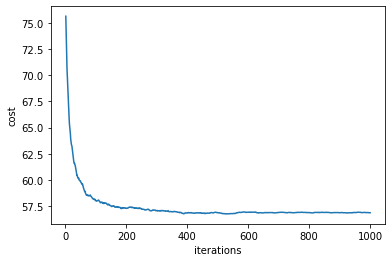

In [6]:

epsilon = np.float(1e-100)

# Sigmoid Function
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

# Predict Function
def predict(X, W):
    return (np.dot(X,W))

# Cross-entropy loss function
def cross_entropy_loss(H, Y):
    Y = np.array(Y)
    return (-Y * np.log(H + epsilon) - (1 - Y) * np.log(1 - H + epsilon)).mean()

# Function to convert probabilities back into class labels
def to_classlabel(z):
    return z.argmax(axis=1)

# Mini-batch Gradient Descent with batch size of 32 samples
def miniBatchGD(X, Y, ytr_enc, alpha, iters, batch_size = 32):
    
    m = (X.shape)[0]
    n = (X.shape)[1] 
    W = np.full((n, 2), 0.1) # n x 3
    inner_iters = math.floor(m/batch_size)
    cost_ = []

    for epoch in range (iters):
        for i in range(inner_iters):

            # Splitting data into batches
            b = i * 32
            batchX = X[b : b + 32]
            batchY = Y[b : b + 32]

            # Performing Gradient descent on the current batch and updating weights accordingly
            H = predict(batchX, W)
            sigm = sigmoid(H) 
            diff = sigm - batchY
            grad = np.dot(batchX.T, diff)
            W -= (alpha * grad)
        
        # Finding cost after each iteration
        H = predict(X, W)
        sigm = sigmoid(H)
        predicted = to_classlabel(sigm)
        cost_.append(cross_entropy_loss(predicted, ytr_enc))

    return W, cost_

epoch = 1000

start_time = time.time()

W_lr, cost_ = miniBatchGD(vecxtr,ytr,ytr_enc,0.001,epoch)

print("--- %s seconds ---" % (time.time() - start_time))

# Plotting cost against number of iterations
epochs = np.arange(1, epoch+1)
plt.plot(epochs, cost_)
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()

### 3.2 k Nearest Neighbors

In [12]:
# Function to calculate cosine similarity between two vectors
def cosine_similarity(P, Q):
    return np.dot(P, Q)/(np.linalg.norm(P)*np.linalg.norm(Q))

# K Nearest Neighbours Function
def KNN(xtr, xte, ytr, k):
    pred = []

    # Iterating through the test data
    for test in xte: 

        # Finding the cosine similarity with entire train data
        d = list(map(lambda train: cosine_similarity(train, test), xtr)) 

        # Adding the correct label next to each distance by makeing a tuple
        di = np.array(list(zip(d, ytr)))

        # Taking only the maximum k distance tuples
        idx = np.argpartition(di[:, 0], k)
        nearest_k = di[idx[::-1][:k]]

        # Extracting the labels only
        nearest_k = nearest_k[:,1] 

        # Finding the mode value for the predicts
        try: 
            most_common = mode(nearest_k) 
            
        # Handling the ties by backing off to k-1 neighbors
        except:
            most_common = mode(nearest_k[:k-1])
        pred.append(most_common)

    pred = [int(i) for i in pred]
    return pred

start_time = time.time()

# Running for k = 1
k_1 = KNN(vecxtr, vecxte, ytr_enc, 1)



print("--- %s seconds ---" % (time.time() - start_time))


--- 687.3358438014984 seconds ---


In [13]:
# Running for k = 3
start_time = time.time()
k_3 = KNN(vecxtr, vecxte, ytr_enc, 3)
print("--- %s seconds ---" % (time.time() - start_time))

--- 703.5744471549988 seconds ---


In [14]:
# Running for k = 5
start_time = time.time()
k_5 = KNN(vecxtr, vecxte, ytr_enc, 5)
print("--- %s seconds ---" % (time.time() - start_time))

--- 702.2141370773315 seconds ---


In [15]:
# Running for k = 7
start_time = time.time()
k_7 = KNN(vecxtr, vecxte, ytr_enc, 7)
print("--- %s seconds ---" % (time.time() - start_time))

--- 701.5105111598969 seconds ---


In [16]:
# Running for k = 10
start_time = time.time()
k_10 = KNN(vecxtr, vecxte, ytr_enc, 10)
print("--- %s seconds ---" % (time.time() - start_time))

--- 714.2522234916687 seconds ---


### 2.3 Perceptron

In [8]:
# Hypothesis function
def hypothesis(X, thetas):
    Z = np.dot(X, thetas.T).reshape(-1,1)
    return Z

# Prediction function that predict whether the label is -1 or 1 for test set using learned perceptron weights
def predict_p(X, thetas):
    H = hypothesis(X, thetas)
    predictions = []
    for i in range(len(H)):
        if H[i] > 0:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions = np.array(predictions).reshape(-1,1)
    return predictions

# Perceptron learning algorithm
def perceptron(X, Y, epoch = 10):

    # Initializing weights with some noise
    w = np.random.rand(1, X.shape[1]+1)
  
    for epoch in range(epoch):
        misclassified = 0
        
        # Looping over each (data, label) pair in the dataset
        for x, y in zip(X, Y):
            x = np.insert(x, 0, 1)

            # Checks if pair (x_i, y_i) is misclassified
            if y * np.dot(w, x.T) <= 0:

                # Updates eights
                w += (y * x)

                # Increments the number of misclassification
                misclassified += 1

        # Breaks out of loop if no value is misclassified
        if misclassified == 0:
            break

    return w

# Converting X train into a matrix             
xtr_p = np.asmatrix(vecxtr, dtype = 'float64')

# Changing class labels from [0, 1] to [-1, 1]
ytr_p = [-1 if i == 0 else 1 for i in ytr_enc]

epoch = 1000

start_time = time.time()

W_p = perceptron(xtr_p, ytr_p, epoch)

print("--- %s seconds ---" % (time.time() - start_time))

--- 441.82872319221497 seconds ---


## 4. Evaluation

In [9]:
def eval(prediction, expected):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for E, P in zip(expected, prediction):
        if E == 0:
            if P == E:
                tn += 1
            else:
                fp += 1
        if E == 1:
            if P == E:
                tp += 1
            else:
                fn += 1

    #Confusion Matrix
    CM = np.array([[tp, fp],[fn, tn]])
    print("\nConfusion Matrix:")
    print(tp, fp)
    print(fn, tp)

    #Precision
    precision = float(tp) / float(tp + fp)
    print("Precision: ", precision)
    
    #Recall
    recall = float(tp) / float(tp + fn)
    print("Recall: ", recall)
    
    #Accuracy
    accuracy = float(tp + tn) / float(tp + fn + tn + fp)
    print("Accuracy: ", accuracy)
    
    #F1 score
    f1_score = (2 * precision * recall) / (precision + recall)
    print("F1 Score: ", f1_score)
    

### 4.1 Logistic Regression

In [10]:
ni = predict(vecxte,W_lr)
sigm = sigmoid(ni)
predicted = to_classlabel(sigm)
eval(predicted, yte)  


Confusion Matrix:
1530 509
550 1530
Precision:  0.7503678273663561
Recall:  0.7355769230769231
Accuracy:  0.7451263537906138
F1 Score:  0.742898761835397


### 4.2 k Nearest Neighbors

In [17]:
print("K = 1")
eval(k_1, yte)
print("\nK = 3")
eval(k_3, yte)
print("\nK = 5")
eval(k_5, yte)
print("\nK = 7")
eval(k_7, yte)
print("\nK = 10")
eval(k_10, yte)

K = 1

Confusion Matrix:
2080 2075
0 2080
Precision:  0.5006016847172082
Recall:  1.0
Accuracy:  0.5006016847172082
F1 Score:  0.6672012830793905

K = 3

Confusion Matrix:
1968 1838
112 1968
Precision:  0.5170782974251182
Recall:  0.9461538461538461
Accuracy:  0.5306859205776173
F1 Score:  0.6687054026503568

K = 5

Confusion Matrix:
1995 1898
85 1995
Precision:  0.5124582584125353
Recall:  0.9591346153846154
Accuracy:  0.5227436823104693
F1 Score:  0.6680060271220492

K = 7

Confusion Matrix:
1982 1861
98 1982
Precision:  0.5157429091855321
Recall:  0.9528846153846153
Accuracy:  0.5285198555956678
F1 Score:  0.6692554448759074

K = 10

Confusion Matrix:
1938 1765
142 1938
Precision:  0.5233594382932757
Recall:  0.9317307692307693
Accuracy:  0.541034897713598
F1 Score:  0.6702403596749092


### 4.3 Perceptron

In [11]:
xte_p = np.c_[ np.ones((vecxte.shape)[0]), vecxte ] 
predicted_p = predict_p(xte_p, W_p)
eval(predicted_p, yte) 


Confusion Matrix:
1934 1535
146 1934
Precision:  0.5575093686941481
Recall:  0.9298076923076923
Accuracy:  0.5954271961492178
F1 Score:  0.697062533789872
